# Observations

- Mouse weight is positively correlated with average tumor volume.
- Capomulin and Ramicane result in a smaller tumor volumes than both Infubinol and Ceftamin.
- Ketapril and Naftisol had the most distributed tumor volumes. 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 10)

mouse_metadata = pd.read_csv('./data/Mouse_metadata.csv')
study_results = pd.read_csv('./data/Study_results.csv')

In [2]:
mouse_metadata

Mouse ID Drug Regimen     Sex  Age_months  Weight (g)
0       k403     Ramicane    Male          21          16
1       s185    Capomulin  Female           3          17
2       x401    Capomulin  Female          16          15
3       m601    Capomulin    Male          22          17
4       g791     Ramicane    Male          11          16
..       ...          ...     ...         ...         ...
244     z314     Stelasyn  Female          21          28
245     z435     Propriva  Female          12          26
246     z581    Infubinol  Female          24          25
247     z795     Naftisol  Female          13          29
248     z969     Naftisol    Male           9          30

[249 rows x 5 columns]

In [3]:
study_results

Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0        b128          0           45.000000                 0
1        f932          0           45.000000                 0
2        g107          0           45.000000                 0
3        a457          0           45.000000                 0
4        c819          0           45.000000                 0
...       ...        ...                 ...               ...
1888     r944         45           41.581521                 2
1889     u364         45           31.023923                 3
1890     p438         45           61.433892                 1
1891     x773         45           58.634971                 4
1892     b879         45           72.555239                 2

[1893 rows x 4 columns]

In [4]:
# Generate a summary statistics table consisting of the mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each drug regimen.

tumor_col = 'Tumor Volume (mm3)'

merged = pd.merge(mouse_metadata, study_results, on='Mouse ID')

# we should end up with one record per study result
assert len(merged) == len(study_results)

grouped = merged.groupby('Drug Regimen')
avg = grouped.mean()[tumor_col]
df = pd.DataFrame(avg).rename(columns={tumor_col: 'mean'})
df['median'] = grouped.median()[tumor_col]
df['variance'] = grouped.var()[tumor_col]
df['standard deviation'] = grouped.std()[tumor_col]
df['SEM'] = grouped.sem()[tumor_col]
df

mean     median   variance  standard deviation       SEM
Drug Regimen                                                               
Capomulin     40.675741  41.557809  24.947764            4.994774  0.329346
Ceftamin      52.591172  51.776157  39.290177            6.268188  0.469821
Infubinol     52.884795  51.820584  43.128684            6.567243  0.492236
Ketapril      55.235638  53.698743  68.553577            8.279709  0.603860
Naftisol      54.331565  52.509285  66.173479            8.134708  0.596466
Placebo       54.033581  52.288934  61.168083            7.821003  0.581331
Propriva      52.322552  50.854632  42.351070            6.507770  0.512884
Ramicane      40.216745  40.673236  23.486704            4.846308  0.320955
Stelasyn      54.233149  52.431737  59.450562            7.710419  0.573111
Zoniferol     53.236507  51.818479  48.533355            6.966589  0.516398

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

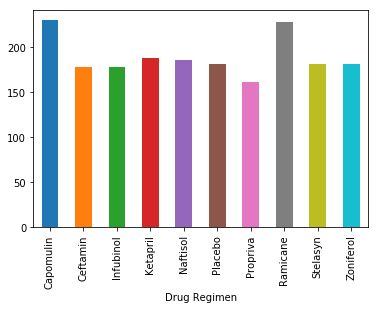

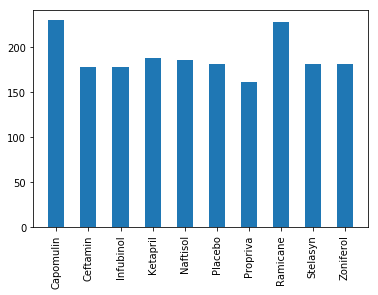

In [5]:
# Generate a bar plot using both Pandas's DataFrame.plot() and Matplotlib's pyplot 
# that shows the number of data points for each treatment regimen.

# NOTE: These plots should look identical.

data_point_counts = grouped.count()['Mouse ID']
data_point_counts.plot(kind='bar')

# the sum of the data point counts should equal the length of the study results.
assert sum(data_point_counts) == len(study_results)

plt.figure()
plt.bar(data_point_counts.index, data_point_counts, width=0.5)
plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'Mouse Genders')

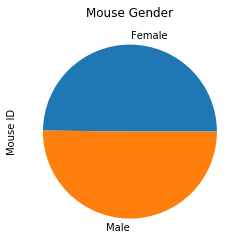

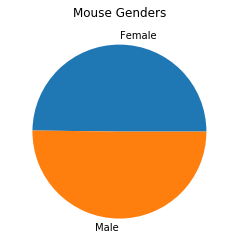

In [6]:
# Generate a pie plot using both Pandas's DataFrame.plot() and Matplotlib's pyplot that shows 
# the distribution of female or male mice in the study.

# NOTE: These plots should look identical.
gender_counts = mouse_metadata.groupby('Sex').count()['Mouse ID']
gender_counts.plot(kind='pie', 
                   title='Mouse Gender')

plt.figure()
plt.pie(gender_counts,
       labels=['Female', 'Male'])
plt.title('Mouse Genders')

In [7]:
# Calculate the final tumor volume of each mouse across four of the most promising 
# treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin. Calculate the 
# quartiles and IQR and quantitatively determine if there are any potential outliers a
# cross all four treatment regimens.

# filter out all other regimens
regs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
predicate = merged['Drug Regimen'].isin(regs)
most_promising = merged[predicate]

# find the max time points for each mouse
max_timepoints = most_promising.groupby('Mouse ID').max()['Timepoint'].to_frame().reset_index() \
    .rename(columns={'Timepoint': 'Max Timepoint'})

# add the max time points for each mouse column and select only the record where a given mouse 
# had the highest time point.
timepoints_merged = pd.merge(most_promising, max_timepoints, on='Mouse ID')
has_max_timepoint = timepoints_merged['Timepoint'] == timepoints_merged['Max Timepoint']
final_tumor_volume = timepoints_merged[has_max_timepoint]

# verify we end up with one record per mouse in the selected regimens
mice_in_promising = mouse_metadata[mouse_metadata['Drug Regimen'].isin(regs)]
assert len(final_tumor_volume) == len(mice_in_promising)

tumor_volumes_summary = final_tumor_volume.groupby('Drug Regimen').describe()['Tumor Volume (mm3)']
tumor_volumes_summary['IQR'] = tumor_volumes_summary['75%'] - tumor_volumes_summary['25%']
tumor_volumes_summary['low outlier boundary'] = tumor_volumes_summary['25%'] - (tumor_volumes_summary['IQR'] * 1.5)
tumor_volumes_summary['high outlier boundary'] = tumor_volumes_summary['75%'] + (tumor_volumes_summary['IQR'] * 1.5)
tumor_volumes_summary.index.names = ['Drug Regimen']
tumor_volumes_summary

count       mean       std        min        25%        50%  \
Drug Regimen                                                                
Capomulin      25.0  36.667568  5.715188  23.343598  32.377357  38.125164   
Ceftamin       25.0  57.753977  8.365568  45.000000  48.722078  59.851956   
Infubinol      25.0  58.178246  8.602957  36.321346  54.048608  60.165180   
Ramicane       25.0  36.191390  5.671539  22.050126  31.560470  36.561652   

                    75%        max        IQR  low outlier boundary  \
Drug Regimen                                                          
Capomulin     40.159220  47.685963   7.781863             20.704562   
Ceftamin      64.299830  68.923185  15.577752             25.355450   
Infubinol     65.525743  72.226731  11.477135             36.832905   
Ramicane      40.659006  45.220869   9.098537             17.912664   

              high outlier boundary  
Drug Regimen                         
Capomulin                 51.832015  
Ceftamin                  87.666458  
Infubinol                 82.741446  
Ramicane                  54.306811

In [8]:
# Potential outliers

# merge the upper and lower boundaries for each study into the table with each mouses final volume
with_boundaries = pd.merge(final_tumor_volume, tumor_volumes_summary.reset_index(), on='Drug Regimen')

# filter out all mouses who have a final volume in the normal range.
low_outlier_filter = with_boundaries[tumor_col] < with_boundaries['low outlier boundary']
high_outlier_filter = with_boundaries[tumor_col] > with_boundaries['high outlier boundary']
assert not any(high_outlier_filter)

# There appears to be no high boundary outliers verify this makes sense
with_boundaries_maxed = with_boundaries.groupby('Drug Regimen').max()
assert all(with_boundaries_maxed[tumor_col] < with_boundaries_maxed['high outlier boundary'])

# only need to include low outliers, since no high outliers exist.
with_boundaries[low_outlier_filter][['Mouse ID', tumor_col, 'low outlier boundary']]


Mouse ID  Tumor Volume (mm3)  low outlier boundary
55     c326           36.321346             36.832905

[Text(0, 0, 'Capomulin'),
 Text(0, 0, 'Ramicane'),
 Text(0, 0, 'Infubinol'),
 Text(0, 0, 'Ceftamin')]

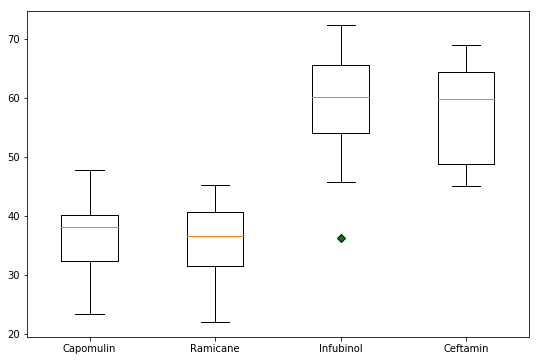

In [9]:
# Using Matplotlib, generate a box and whisker plot of the final tumor volume for all four treatment 
# regimens and highlight any potential outliers in the plot by changing their color and style.
# Hint: All four box plots should be within the same figure. Use this Matplotlib documentation page 
# for help with changing the style of the outliers.

# create four separate data sets
regimen_filters = [final_tumor_volume['Drug Regimen'] == r for r in regs]
regimens = [final_tumor_volume[rf][tumor_col] for rf in regimen_filters]

# create box plots
green_diamond = dict(markerfacecolor='g', marker='D')
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(regimens, flierprops=green_diamond)
ax.set_xticklabels(regs)

In [10]:
# Generate a line plot of time point versus tumor volume for a single mouse treated with Capomulin.

# get a commonly monitored mouse
capomulin = merged[merged['Drug Regimen'] == 'Capomulin']
common_mouse = capomulin.groupby('Mouse ID').count().sort_values(tumor_col, ascending=False).reset_index().iloc[0]['Mouse ID']

common_mouse_filter = study_results['Mouse ID'] == common_mouse
common_mouse_data = study_results[common_mouse_filter]

plt.plot(common_mouse_data['Timepoint'], common_mouse_data[tumor_col])
plt.title(f'{ tumor_col } of mouse { common_mouse }')

Text(0.5, 1.0, 'Tumor Volume (mm3) of mouse b128')

In [11]:
# Generate a scatter plot of average mouse weight versus average tumor volume for the Capomulin treatment regimen.

# get average weight and tumor volume per mouse
avg_tumor = capomulin.groupby('Mouse ID').mean().reset_index().rename(columns={
    tumor_col: 'Average Tumor Size',
    'Weight (g)': 'Average Weight',
})

# capomulin_with_avg = pd.merge(avg_tumor, capomulin, on='Mouse ID')
avg_tumor.plot('Average Weight', 
               'Average Tumor Size', 
               kind='scatter', 
               title='Capomulin Mouse Weight to Average Tumor Volume')

# Calculate the correlation coefficient and linear regression model between mouse weight and 
# average tumor volume for the Capomulin treatment. Plot the linear regression model on top 
# of the previous scatter plot.

from scipy.stats import linregress
x = avg_tumor['Average Weight']
regression = linregress(x, avg_tumor['Average Tumor Size'])
plt.plot(x, regression.intercept + regression.slope * x)

print(f'Correlation coefficient: { regression.rvalue }')

Correlation coefficient: 0.8419363424694719
